In [3]:
from time import time
import lightgbm as lgb
import numpy as np
import sys
# sys.path.append('..\Python Scripts\pipeline')
import warnings
warnings.filterwarnings('ignore') 
import seaborn as sns
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.stats import uniform
import datetime
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from scipy import stats
# from hyperopt import hp, tpe
# from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, validation_curve, KFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
%matplotlib inline
import gc

# Funcs

In [4]:
def num_cat(df):
    '''
    Функция возвращает куски исходного датафрейма. Куски состоят из категориальных фич и из числовых
    '''
    categorical_features = df.select_dtypes(include = ["object"]).columns
    numerical_features = df.select_dtypes(exclude = ["object"]).columns
    if 'target' in numerical_features:
        numerical_features = numerical_features.drop('target')
    print("Numerical features : " + str(len(numerical_features)))
    print("Categorical features : " + str(len(categorical_features)))

    df_num = df[numerical_features]
    df_cat = df[categorical_features]
    return df_num, df_cat
def missing_values_table(df):
    '''
    Функция возвращает таблицу с количеством и долей пропущенных значений в датафрейме
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns
def reduce_memory_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object) & (col_type != 'datetime64[ns]'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum()/1024**2
    print('Memory usage: Before|{:.2f} MB || After|{:.2f} MB || Decreased|{:.1f}%'.format(start_mem, end_mem, 100*(1 - end_mem/start_mem)))
    
    return df 
def fast_validate_kfold(test, X, y, params):
    preds = np.zeros(len(test))
    oof = np.zeros(len(X))

    folds = KFold(n_splits=5, shuffle=False)

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()

    print('Start')
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):

        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

        clf = lgb.train(params,
                        trn_data,
                        100,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=200,
                        early_stopping_rounds=200)

        preds += clf.predict(test)
        oof[test_idx] = clf.predict(X.iloc[test_idx])
        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('OOF AUC:', roc_auc_score(y, oof))
    print('-' * 30)

    feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#     feature_importances.to_csv('feature_importances.csv')


    plt.figure(figsize=(16, 16))
    sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
    plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
    
    return clf, feature_importances, preds/folds.n_splits
def submission_validate_kfold(test, X, y, params):
    preds = np.zeros(len(test))
    oof = np.zeros(len(X))

    folds = KFold(n_splits=5, shuffle=False)

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()

    print('Start')
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):

        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

        clf = lgb.train(params,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=500)

        preds += clf.predict(test)
        oof[test_idx] = clf.predict(X.iloc[test_idx])
        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('OOF AUC:', roc_auc_score(y, oof))
    print('-' * 30)

    feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#     feature_importances.to_csv('feature_importances.csv')


    plt.figure(figsize=(16, 16))
    sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
    plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
    
    return clf, feature_importances, preds/folds.n_splits
def outliers(i, df, col):
    scaled = StandardScaler().fit_transform(df[col].dropna()[:, np.newaxis])
    
    low_range = scaled[scaled[:,0].argsort()][:10]
    high_range= scaled[scaled[:,0].argsort()][-10:]
    if len(np.unique(low_range)) >= 2 or len(np.unique(high_range)) >= 2:
        print(i, col)
        print('outer range (low) of the distribution:')
        print(low_range)
        print('\nouter range (high) of the distribution:')
        print(high_range)
        print('\n')

        return col, (high_range[-1]/high_range[0])[0], (low_range[-1]/low_range[0])[0]
def kde_target(var_name, df):    
    corr = df['isFraud'].corr(df[var_name])
    avg_repaid = df.loc[df['isFraud'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['isFraud'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 9))
    
    sns.kdeplot(df.loc[df['isFraud'] == 0, var_name], label = 'isFraud == 0')
    sns.kdeplot(df.loc[df['isFraud'] == 1, var_name], label = 'isFraud == 1')
    
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution' % var_name)
    plt.legend()
    
    print('The correlation between %s and the isFraud is %0.4f' % (var_name, corr))
def check_outliers(df, col):
    
    sns.distplot(df[col].dropna())
    kde_target(col, df)
    return df[col].value_counts().sort_index()

# Read data

##### прочитать данные с нуля

In [34]:
# folder_path = '../input/'
# subm = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/sample_submission.csv'))

# te_id = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/test_identity.csv'))
# te_tr = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/test_transaction.csv'))
# tr_id = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/train_identity.csv'))
# tr_tr = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/train_transaction.csv'))


# subm = reduce_memory_usage(pd.read_csv(f'../ieee/input/sample_submission.csv'))
# te_id = reduce_memory_usage(pd.read_csv(f'../ieee/input/test_identity.csv'))
# te_tr = reduce_memory_usage(pd.read_csv(f'../ieee/input/test_transaction.csv'))
# tr_id = reduce_memory_usage(pd.read_csv(f'../ieee/input/train_identity.csv'))
# tr_tr = reduce_memory_usage(pd.read_csv(f'../ieee/input/train_transaction.csv'))

# files = ['../ieee/input/test_identity.csv', 
#          '../ieee/input/test_transaction.csv',
#          '../ieee/input/train_identity.csv',
#          '../ieee/input/train_transaction.csv',
#          '../ieee/input/sample_submission.csv']

In [178]:
files = ['ieee/test_identity.csv', 
         'ieee/test_transaction.csv',
         'ieee/train_identity.csv',
         'ieee/train_transaction.csv',
         'ieee/sample_submission.csv']

In [179]:
%%time
def load_data(file):
    return pd.read_csv(file)

test_id, test_tr, train_id, train_tr, sub = map(load_data, files)

Wall time: 1min 1s


In [180]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

56

In [181]:
train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

Memory usage: Before|1959.88 MB || After|650.48 MB || Decreased|66.8%
Memory usage: Before|1677.73 MB || After|565.37 MB || Decreased|66.3%


In [182]:
tr_num, tr_cat = num_cat(train)
te_num, te_cat = num_cat(test)

Numerical features : 403
Categorical features : 31
Numerical features : 402
Categorical features : 31


In [ ]:
# with pd.HDFStore('./hdf/store_v1.h5',complib='blosc:blosclz') as store:
#     store.put('train',train)
#     store.put('test',test)

##### прочитать train и test из hdfs

In [183]:
with pd.HDFStore('./hdf/store_v1.h5',complib='blosc:blosclz') as store:
    train = store['train']
    test = store['test']

# Features

In [187]:
print(train.shape, test.shape)

(590540, 434) (506691, 433)


In [188]:
start_date = '2017-12-01' 
startdate = datetime.datetime.strptime(start_date, "%Y-%m-%d") 

for dataset in (train, test): 
    dataset["Date"] = dataset['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x))) 
    dataset['Weekdays'] = dataset['Date'].dt.dayofweek 
    dataset['Hours'] = dataset['Date'].dt.hour 
    dataset['Days'] = dataset['Date'].dt.day 
    dataset['isNight'] = dataset['Hours'].map(lambda x: 1 if (x >= 23 or x < 5) else 0)

In [189]:
train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

In [190]:
train['nulls1'] = train.isna().sum(axis=1)
test['nulls1'] = test.isna().sum(axis=1)

In [191]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 
          'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 
          'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 
          'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 
          'hotmail.com': 'microsoft', 'protonmail.com': 'other', 
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 
          'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 
          'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other',
          'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com':
          'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 
          'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 
          'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 
          'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [ ]:
many_same_values_columns_train = [c for c in train.columns if train[c].value_counts(normalize=True).values[0] > 0.98]
many_same_values_columns_test = [c for c in test.columns if test[c].value_counts(normalize=True).values[0] > 0.98]

columns_to_drop = list(set(many_same_values_columns_train + many_same_values_columns_test))

if 'isFraus' in columns_to_drop:
    columns_to_drop.remove('isFraud')

In [22]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 
                   'OS_id_30', 
                   'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id']

In [192]:
c_t_drop = []
for c in columns_to_drop:
    if c not in useful_features:
        c_t_drop.append(c)

for df in [train, test]:
    df.drop(c_t_drop, axis=1, inplace=True)

In [196]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

#     dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
#     dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

train = id_split(train)
test = id_split(test)

train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
test['TransactionAmt_Log'] = np.log(test['TransactionAmt'])

for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = preprocessing.LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

In [198]:
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

for feature in [ 'id_36']:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        

for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [199]:
for f in train.columns:
    if  train[f].dtype=='object': 
        train[f] = train[f].replace("nan", "other")
        train[f] = train[f].replace(np.nan, "other")
        test[f] = test[f].replace("nan", "other")
        test[f] = test[f].replace(np.nan, "other")
        
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))  


In [200]:
with pd.HDFStore('./hdf/store_v1.h5',complib='blosc:blosclz') as store:
    store.put('allfeat_train',train)
    store.put('allfeat_test',test)

In [5]:
with pd.HDFStore('./hdf/store_v1.h5',complib='blosc:blosclz') as store:
    train_allkernel = store['allfeat_train']
    test_allkernel = store['allfeat_test']

In [6]:
train = train_allkernel
test = test_allkernel

##### подготовка к моделированию

In [7]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test#.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

X.drop('Date', axis=1, inplace=True)
test.drop('Date', axis=1, inplace=True)

# with pd.HDFStore('./hdf/store_v1.h5',complib='blosc:blosclz') as store:
#     store.put('nroman_train',train)
#     store.put('nroman_test',test)

# Model

##### nroman

In [59]:
params = {'num_leaves': 500,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.05,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'n_jobs':3
         }

clf_nr, feature_importances_nr, preds_nr = validate_kfold(test, X, y, params)

##### all features from kernels

Start
Training on fold 1
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.992734	valid_1's auc: 0.910869
Fold 1 finished in 0:02:33.639032
Training on fold 2
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.993308	valid_1's auc: 0.930493
Fold 2 finished in 0:02:34.028523
Training on fold 3
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.993312	valid_1's auc: 0.930928
Fold 3 finished in 0:02:35.990002
Training on fold 4
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.993124	valid_1's auc: 0.947639
Fold 4 finished in 0:02:35.962996
Training on fold 5
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best it

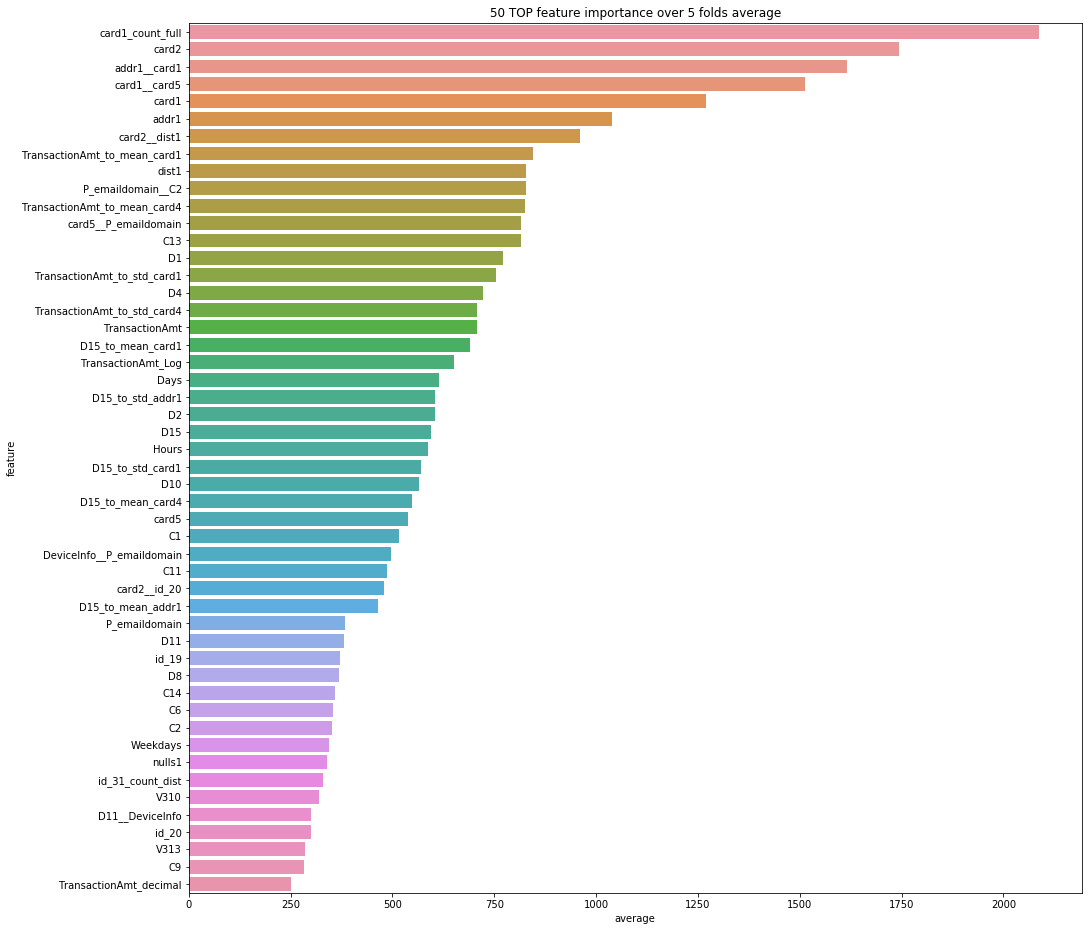

In [207]:
params = {'num_leaves': 500,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.05,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'n_jobs':3
         }

clf_allfeat, feature_importances_allfeat, preds_allfeat = fast_validate_kfold(test, X, y, params)

Start
Training on fold 1
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.974039	valid_1's auc: 0.900163
[1000]	training's auc: 0.993091	valid_1's auc: 0.913198
[1500]	training's auc: 0.998335	valid_1's auc: 0.917447
[2000]	training's auc: 0.999598	valid_1's auc: 0.918997
[2500]	training's auc: 0.999904	valid_1's auc: 0.919364
[3000]	training's auc: 0.999982	valid_1's auc: 0.919758
[3500]	training's auc: 0.999997	valid_1's auc: 0.920023
[4000]	training's auc: 1	valid_1's auc: 0.920268
[4500]	training's auc: 1	valid_1's auc: 0.920184
Early stopping, best iteration is:
[4320]	training's auc: 1	valid_1's auc: 0.920288
Fold 1 finished in 1:04:13.393544
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.973975	valid_1's auc: 0.919872
[1000]	training's auc: 0.993864	valid_1's auc: 0.932846
[1500]	training's auc: 0.998744	valid_1's auc: 0.936619
[2000]	training's auc: 0.999744	valid_1's auc: 0.937747


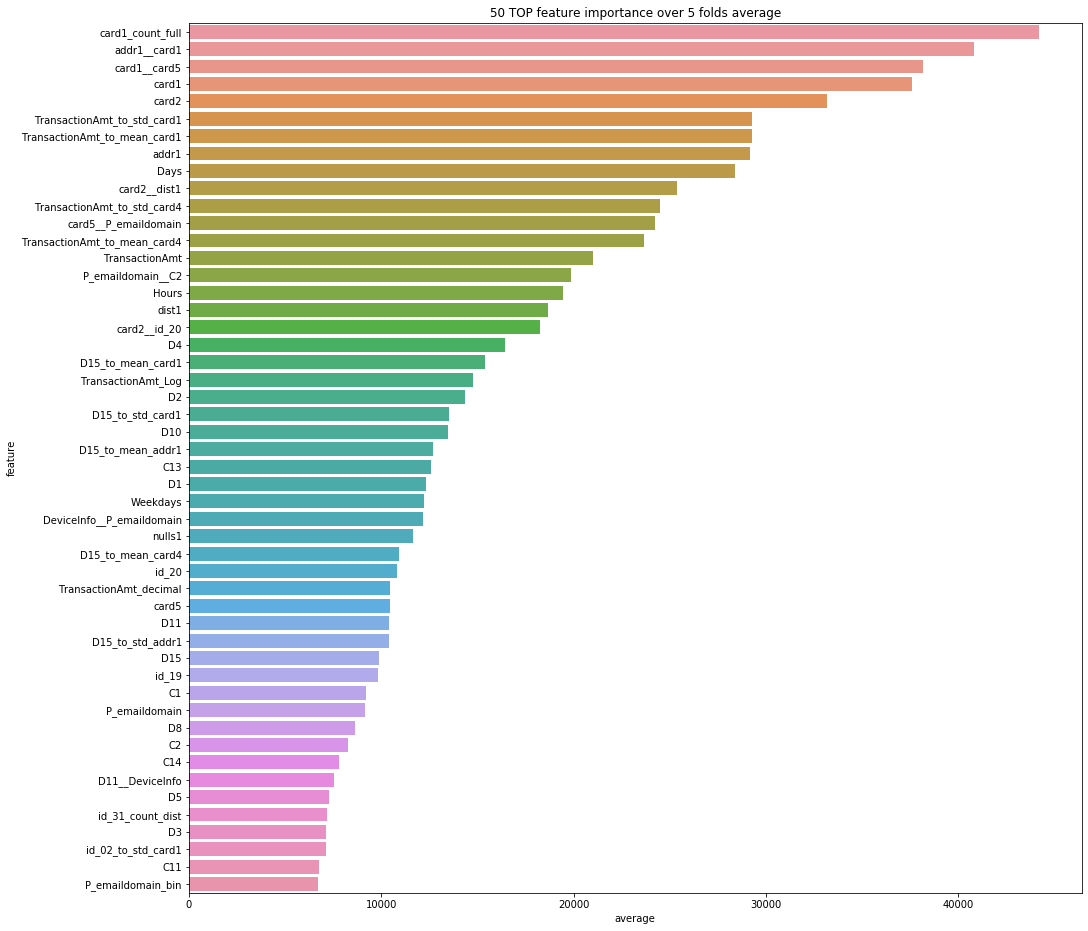

In [208]:
params = {'num_leaves': 500,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 120,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 1,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'n_jobs':3,
          'random_seed': 0
         }
clf_allfeat_sub, feature_importances_allfeat_sub, preds_allfeat_sub = submission_validate_kfold(test, X, y, params)

In [209]:
preds_allfeat_sub

array([0.00058272, 0.00159319, 0.0030339 , ..., 0.00399546, 0.00662631,
       0.00464445])

In [ ]:
preds

# Experiments

##### outliers

In [9]:
q=0
outliers_list = []
for i, col in enumerate(train.columns):
    k = outliers(i, train, col)
    if k is not None:
        outliers_list.append(k)

0 TransactionID
outer range (low) of the distribution:
[[-1.73204787]
 [-1.73204201]
 [-1.73203614]
 [-1.73203028]
 [-1.73202441]
 [-1.73201854]
 [-1.73201268]
 [-1.73200681]
 [-1.73200095]
 [-1.73199508]]

outer range (high) of the distribution:
[[1.73199508]
 [1.73200095]
 [1.73200681]
 [1.73201268]
 [1.73201854]
 [1.73202441]
 [1.73203028]
 [1.73203614]
 [1.73204201]
 [1.73204787]]


2 TransactionDT
outer range (low) of the distribution:
[[-1.57798669]
 [-1.57798648]
 [-1.57797175]
 [-1.57796525]
 [-1.57796374]
 [-1.57796287]
 [-1.57796027]
 [-1.57795876]
 [-1.57795746]
 [-1.57795724]]

outer range (high) of the distribution:
[[1.82763983]
 [1.82764178]
 [1.82765737]
 [1.82766214]
 [1.82766235]
 [1.82766604]
 [1.82766647]
 [1.82767297]
 [1.82767491]
 [1.82768423]]


5 card1
outer range (low) of the distribution:
[[-1.81563625]
 [-1.81543222]
 [-1.81543222]
 [-1.81543222]
 [-1.81482012]
 [-1.81482012]
 [-1.81482012]
 [-1.81482012]
 [-1.81482012]
 [-1.81461608]]

outer range (high) of

ValueError: Input contains infinity or a value too large for dtype('float16').

In [25]:
outlier_df = pd.DataFrame(outliers_list).sort_values(by=[1], ascending=False)
outlier_df

,0,1,2
237,id_02_to_std_card1,140.660370,0.999696
217,V338,4.844497,1.000000
218,V339,4.835474,1.000000
216,V337,4.827401,1.000000
143,V214,4.824398,1.000000
144,V215,4.571065,1.000000
145,V216,4.561337,1.000000
176,V263,3.562519,1.000000
180,V276,3.542206,1.000000
205,V319,3.541044,1.000000


In [37]:
feat_outlier = set(useful_features) & set(outlier_df[outlier_df[1] > 3][0])
feat_outlier

{'V214', 'V215', 'V216', 'V226', 'V263', 'V265', 'V276', 'V338'}

The correlation between V214 and the isFraud is 0.0049
The correlation between V263 and the isFraud is 0.0147
The correlation between V338 and the isFraud is -0.0194
The correlation between V265 and the isFraud is 0.0142
The correlation between V216 and the isFraud is -0.0006
The correlation between V215 and the isFraud is -0.0048
The correlation between V276 and the isFraud is 0.0097
The correlation between V226 and the isFraud is 0.0023


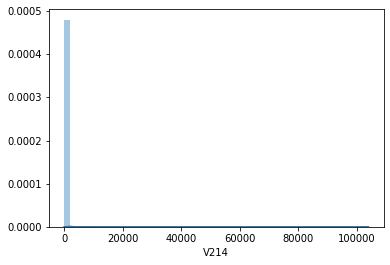

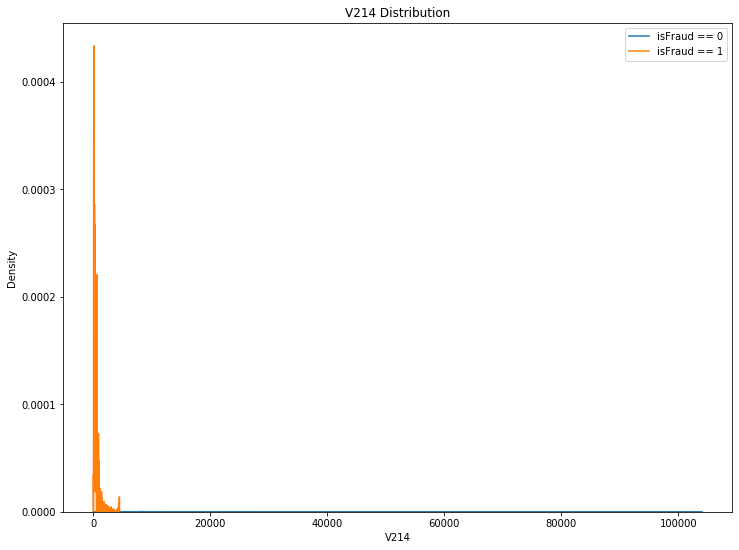

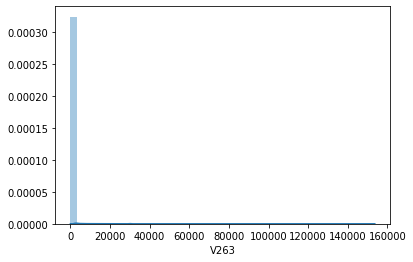

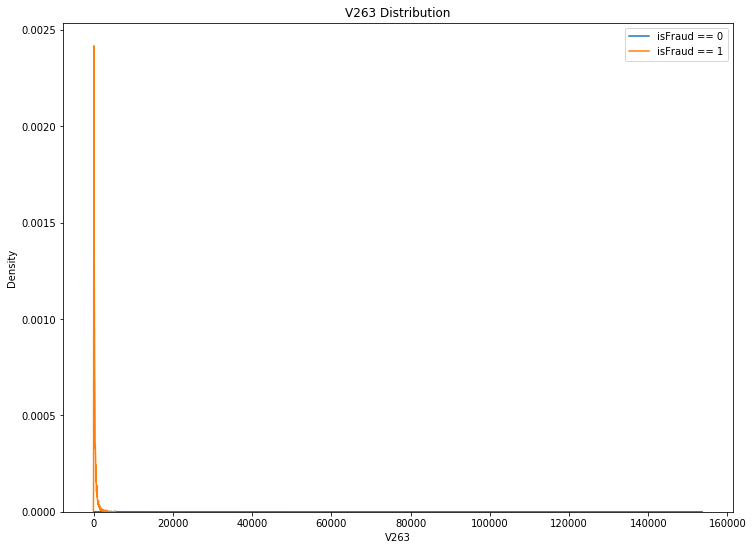

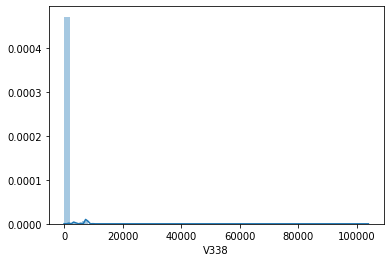

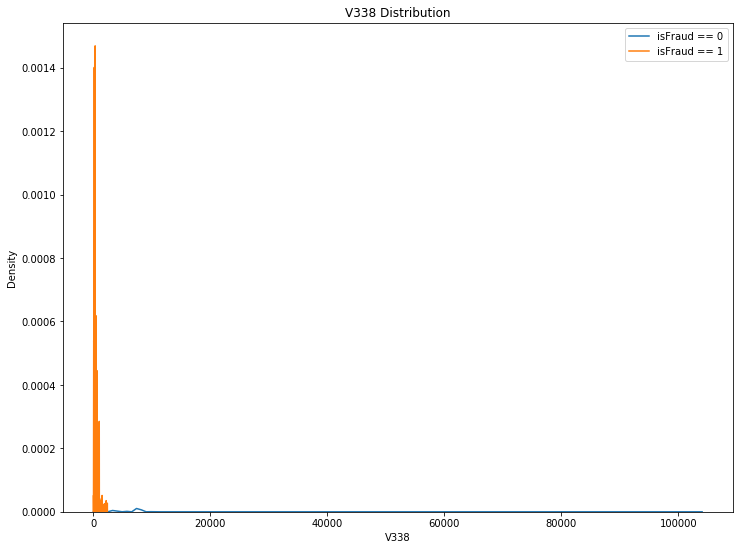

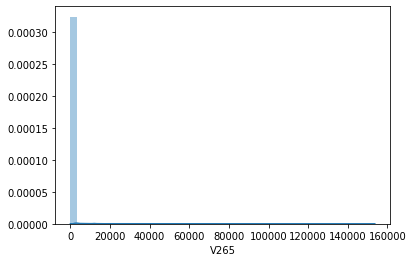

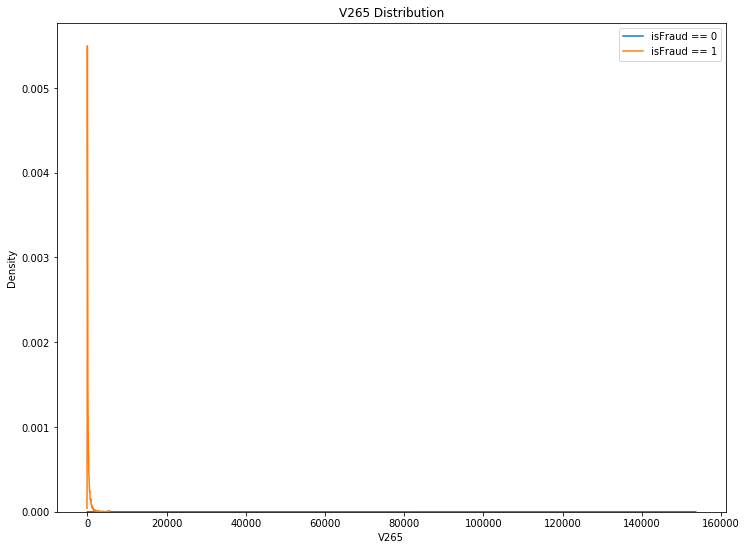

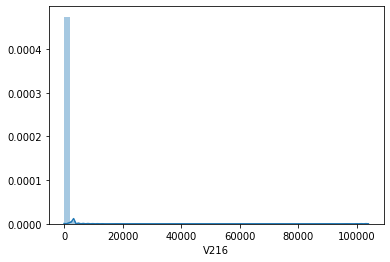

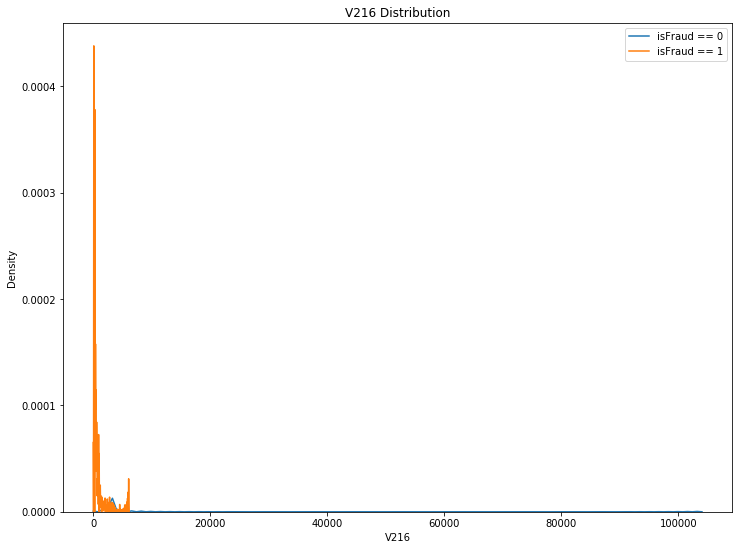

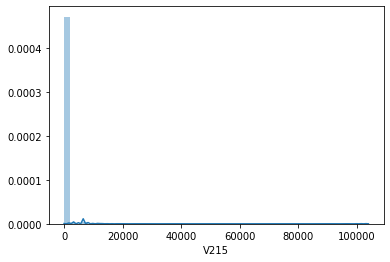

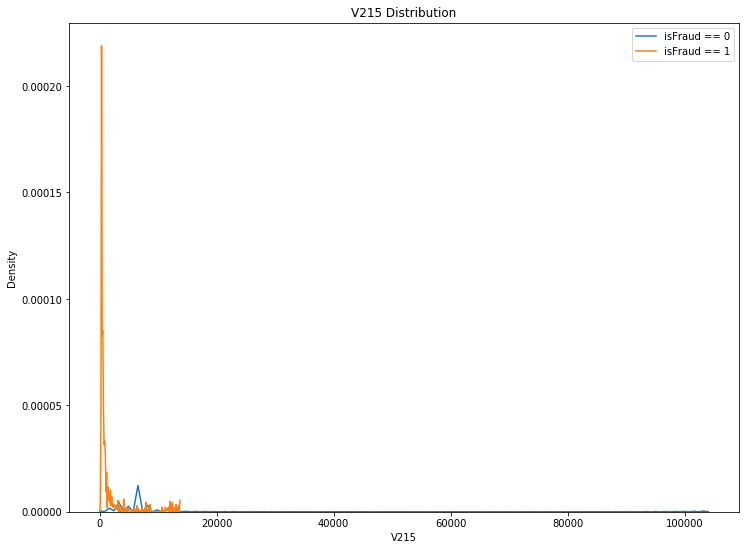

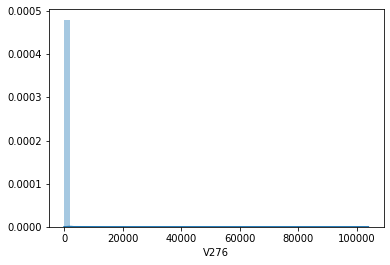

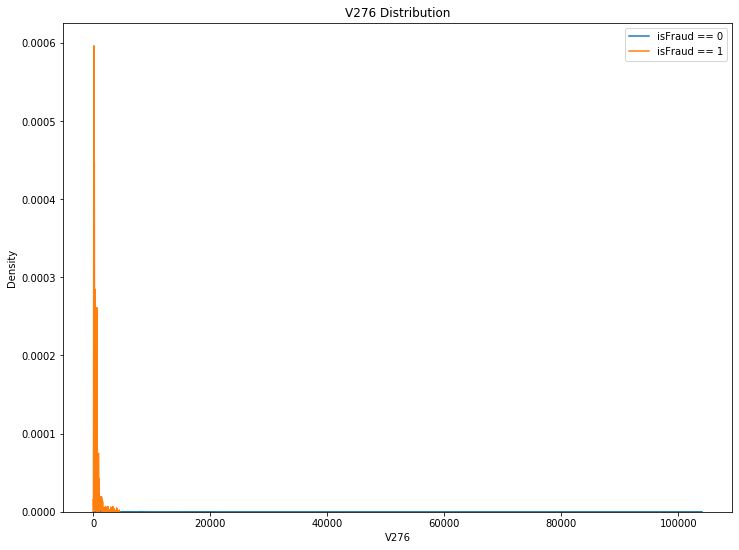

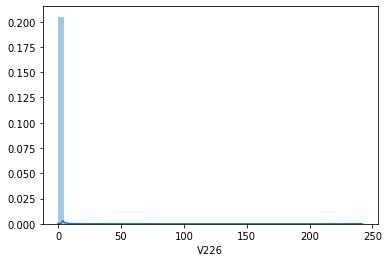

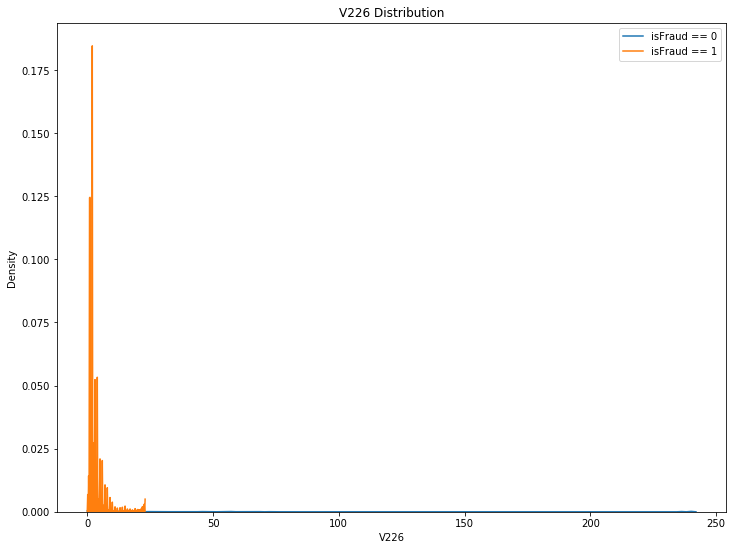

In [39]:
for feat in feat_outlier:
    plt.figure()
    check_outliers(train, feat)

The correlation between id_02_to_std_card1 and the isFraud is -0.0012


0.000009        1
0.000019        1
0.000211        1
0.000464        1
0.000503        1
               ..
1075.365479     1
1781.185181     1
1782.599365     1
55459.445312    1
55460.859375    1
Name: id_02_to_std_card1, Length: 136425, dtype: int64

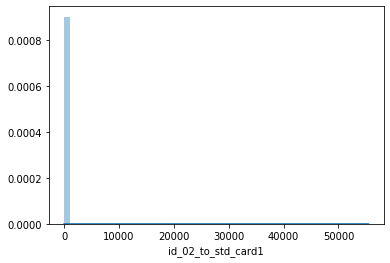

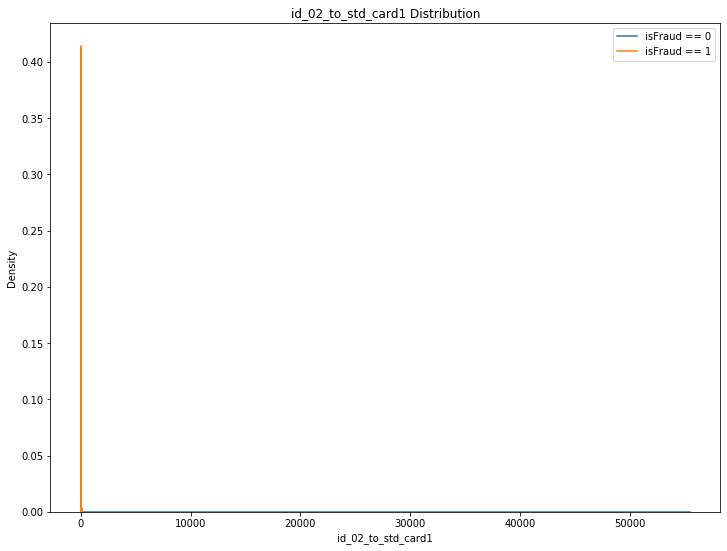

In [11]:
check_outliers(train, 'id_02_to_std_card1')

In [15]:
train['id_02_to_std_card1'].value_counts().sort_index()

0.000009        1
0.000019        1
0.000211        1
0.000464        1
0.000503        1
               ..
1075.365479     1
1781.185181     1
1782.599365     1
55459.445312    1
55460.859375    1
Name: id_02_to_std_card1, Length: 136425, dtype: int64

In [20]:
test['id_02_to_std_card1'].value_counts().sort_index()

0.000046       1
0.000064       1
0.000079       1
0.000111       1
0.000195       1
              ..
1325.781006    1
1327.195312    1
4804.592773    1
4806.006836    1
inf            6
Name: id_02_to_std_card1, Length: 132976, dtype: int64

In [17]:
train[train['id_02_to_std_card1'] == 55460.859375]['id_02_to_std_card1']

25533    55460.859375
Name: id_02_to_std_card1, dtype: float32

In [18]:
train[train['id_02_to_std_card1'] == 55459.445312]['id_02_to_std_card1']

99336    55459.445312
Name: id_02_to_std_card1, dtype: float32

The correlation between V339 and the isFraud is -0.0147


0.0         72799
5.0            19
6.0             5
7.0             3
8.0             3
            ...  
43200.0         1
51200.0         3
52030.0         1
64800.0         1
104060.0        1
Name: V339, Length: 334, dtype: int64

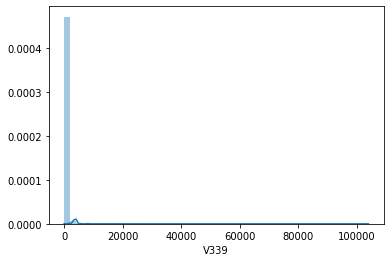

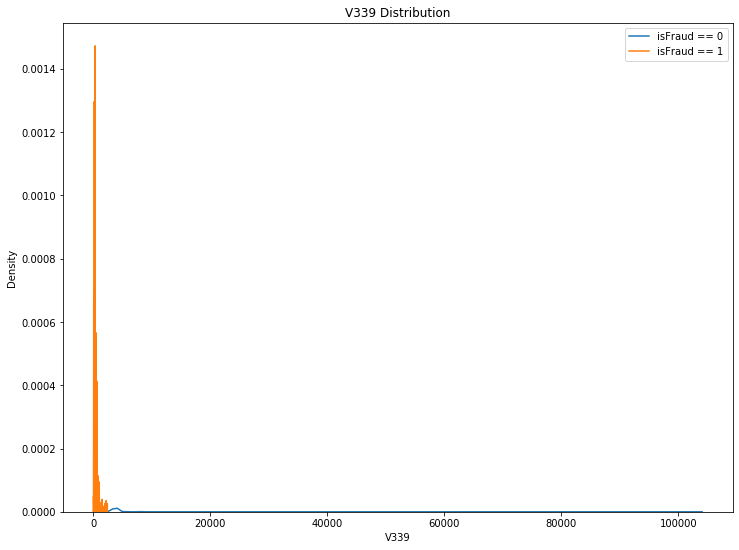

In [21]:
check_outliers(train, 'V339')

In [115]:
check_outliers(train, 'V240')

check_outliers(train, 'V338')

0 TransactionID
outer range (low) of the distribution:
[[-1.73204787]
 [-1.73204201]
 [-1.73203614]
 [-1.73203028]
 [-1.73202441]
 [-1.73201854]
 [-1.73201268]
 [-1.73200681]
 [-1.73200095]
 [-1.73199508]]

outer range (high) of the distribution:
[[1.73199508]
 [1.73200095]
 [1.73200681]
 [1.73201268]
 [1.73201854]
 [1.73202441]
 [1.73203028]
 [1.73203614]
 [1.73204201]
 [1.73204787]]


2 TransactionDT
outer range (low) of the distribution:
[[-1.57798669]
 [-1.57798648]
 [-1.57797175]
 [-1.57796525]
 [-1.57796374]
 [-1.57796287]
 [-1.57796027]
 [-1.57795876]
 [-1.57795746]
 [-1.57795724]]

outer range (high) of the distribution:
[[1.82763983]
 [1.82764178]
 [1.82765737]
 [1.82766214]
 [1.82766235]
 [1.82766604]
 [1.82766647]
 [1.82767297]
 [1.82767491]
 [1.82768423]]


5 card1
outer range (low) of the distribution:
[[-1.81563625]
 [-1.81543222]
 [-1.81543222]
 [-1.81543222]
 [-1.81482012]
 [-1.81482012]
 [-1.81482012]
 [-1.81482012]
 [-1.81482012]
 [-1.81461608]]

outer range (high) of

ValueError: Input contains infinity or a value too large for dtype('float16').

##### check outlier detection uplift

In [ ]:
params = {'num_leaves': 500,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.05,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'n_jobs':3
         }

clf_allfeat, feature_importances_allfeat, preds_allfeat = fast_validate_kfold(test, X, y, params)

##### mean target encoding

##### если разница между предсказанием и таргетом большая, выкинуть из обучения/предсказания?

##### откалибровать переменные на уровень таргета (прогнать через логрег с однйо переменной) и заполнить пропуски средним таргетом

# Different models for blending

##### cat

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y),
                                                 y)

clf = CatBoostClassifier(task_type='GPU', eval_metric='AUC', loss_function='Logloss', 
                         max_leaves=48, max_depth=-1, class_weights=class_weights, silent=True, random_state=0)

clf.fit(X, y, verbose=True)

probs = clf.predict_proba(test, verbose=1)

##### rf

In [ ]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators=10000, max_depth=2,  random_state=0)

clf.fit(X, y)  

# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=2, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
#             oob_score=False, random_state=0, verbose=0, warm_start=False)


print(clf.feature_importances_)

preds = clf.predict(test)

# Submission

In [ ]:
subm['isFraud'] = preds / folds.n_splits

In [ ]:
all_blends =  pd.read_csv(f'../ieee/input/sample_submission.csv', index_col=0)

sub = all_blends.copy()
sub['isFraud'] =all_blends['isFraud'].values*0.6 + subm['isFraud'].values*0.4

sub.to_csv('try5.csv', float_format='%.6f')

In [211]:
sub = pd.read_csv('ieee/sample_submission.csv')

In [212]:
sub['isFraud'] = preds_allfeat_sub

In [216]:
sub.to_csv('try5.csv', index=False)

In [ ]:
# subm['isFraud'] = result_dict_lgb['prediction']
# # sub.to_csv('submission.csv', index=False)



# all_blends =  pd.read_csv(f'../ieee/input/sample_submission.csv', index_col=0)

# sub = all_blends.copy()
# sub['isFraud'] =all_blends['isFraud'].values*0.6 + subm['isFraud'].values*0.4

# sub.to_csv('try4.csv', float_format='%.6f')